<a href="https://colab.research.google.com/github/SM24-Industrial-Software-Dev/ML-forecasting-NOx-levels/blob/ES-33-forecasting-model/NOxDailyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup code here

#### Fetches required notebooks from our Github repo

In [ ]:
!git clone -b ES-33-forecasting-model https://github.com/SM24-Industrial-Software-Dev/ML-forecasting-NOx-levels
!cp ML-forecasting-NOx-levels/API/Receive_Conc_API.ipynb .
!cp ML-forecasting-NOx-levels/MSA_class.ipynb .

Cloning into 'ML-forecasting-NOx-levels'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 52), reused 5 (delta 5), pack-reused 56
Receiving objects: 100% (180/180), 1.19 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (70/70), done.


#### Pip install and sts-jax update

In [ ]:
!pip install git+https://github.com/rameshnatarajanus/sts-jax@get-fit_hmc-to-work
!pip install import-ipynb

  Cloning https://github.com/rameshnatarajanus/sts-jax (to revision get-fit_hmc-to-work) to /tmp/pip-req-build-vvgmw8pj
  Running command git clone --filter=blob:none --quiet https://github.com/rameshnatarajanus/sts-jax /tmp/pip-req-build-vvgmw8pj
  Running command git checkout -b get-fit_hmc-to-work --track origin/get-fit_hmc-to-work
  Switched to a new branch 'get-fit_hmc-to-work'
  Branch 'get-fit_hmc-to-work' set up to track remote branch 'get-fit_hmc-to-work' from 'origin'.
  Resolved https://github.com/rameshnatarajanus/sts-jax to commit 1cb6767f9430f65fed5b86c4ce210327cc418e6b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/probml/dynamax.git to /tmp/pip-install-z8lswuky/dynamax_ccb9898a6408499da670266493934a85
  Running command git clone --filter=blob:none --quiet https://github.com/probml/dynamax.git /tmp/pip-install-z8lswuky/dynamax_ccb9898a6408499da670266493934

#### Required Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.random as jr
import sts_jax.structural_time_series as sts
import ee

import import_ipynb
from MSA_class import MSA
from Receive_Conc_API import get_nox_data

#### MSA creation and a helper function

In [ ]:
msa = MSA()

In [54]:
def get_complete_nox_data(area: ee.featurecollection.FeatureCollection, start_date: str, end_date: str, surround: int) -> pd.DataFrame:
  """
  Gets the NOx data for a given area and date range.

  Args:
    area (FeatureCollection): The MSA to get the data for.
    start_date (str): The start date of the data.
    end_date (str): The end date of the data.
    surround (int): The number of surrounding values to use to fill missing values.

  Returns:
    A pandas DataFrame with the NOx data.
  """
  # Get the data from the API
  df = get_nox_data(area, start_date, end_date)
  # Create a complete date range
  dates = pd.date_range(start_date, end_date)
  df = pd.merge(pd.DataFrame({'date': dates}), df, on='date', how='left')
  # Fill missing values
  df['nox-concentration'] = df['nox-concentration'].fillna(df['nox-concentration'].rolling(surround + 1, center=True, min_periods=1).mean())

  return df

### Read the NOx data from the API and check it out

In [55]:
# Choose the desired MSA
current_msa = msa.names[4]
# Choose the desired date range
start_date = "2023-02-01"
end_date = "2024-07-01"
# Choose the desired number of surrounding values to use to fill missing values
surround = 6

# Get the NOx data for the desired MSA and date range
df = get_complete_nox_data(msa.get_areas(current_msa), start_date, end_date, surround)

#### Check out the data

In [56]:
display(df)

,date,nox-concentration,system:index
0,2023-02-01,0.000050,NaN
1,2023-02-02,0.000041,NaN
2,2023-02-03,0.000043,NaN
3,2023-02-04,0.000050,3
4,2023-02-05,0.000033,4
...,...,...,...
512,2024-06-27,0.000019,512
513,2024-06-28,0.000029,NaN
514,2024-06-29,0.000030,514
515,2024-06-30,0.000009,515


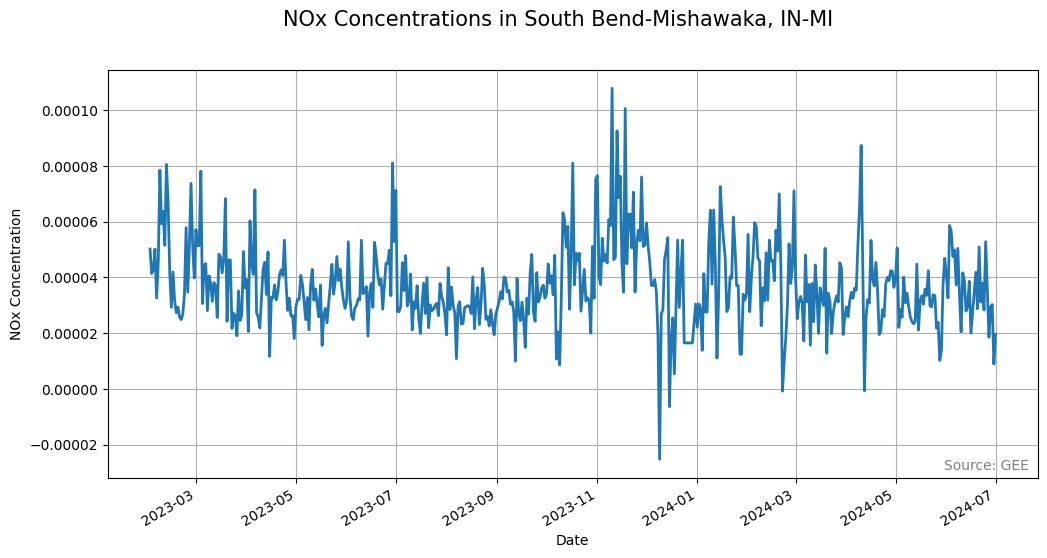

In [57]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(df['date'].to_numpy()),
        jnp.array(df['nox-concentration'].to_numpy(), dtype=np.float32),
        lw=2,
        label='training data',
        markersize=1)
ax.grid()

ax.set_ylabel("NOx Concentration")
ax.set_xlabel("Date")

fig.suptitle(f"NOx Concentrations in {current_msa}", fontsize=15)
ax.text(
    0.99,
    0.02,
    "Source: GEE", # Add link
    transform=ax.transAxes,
    horizontalalignment='right',
    alpha=0.5
)
fig.autofmt_xdate()

### Build STS models

In [58]:
def get_training_data(num_weeks: int, NOx_df: pd.DataFrame):
    num_forecast_steps = num_weeks * 7
    NOx_concentrations = jnp.array(NOx_df['nox-concentration'].to_numpy().astype(np.float32))
    dates = np.array(NOx_df['date'].to_numpy())

    obs_time_series = NOx_concentrations[:-num_forecast_steps, None]  # training data
    obs_dates = dates[:-num_forecast_steps]  # training data dates
    actual_time_series = NOx_concentrations[:, None] # actual data (training and validation)
    actual_dates = dates

    # The model includes the local linear trend component and a seasonal component
    trend = sts.LocalLinearTrend()
    seasonal_dummy = sts.SeasonalDummy(num_seasons=7)
    seasonal_trig = sts.SeasonalTrig(num_seasons=7)

    def create_model(seasonal_component):
        return sts.StructuralTimeSeries([trend, seasonal_component],
                                        obs_distribution='Gaussian',
                                        obs_time_series=obs_time_series)

    model_dummy_season = create_model(seasonal_dummy)
    model_trig_season = create_model(seasonal_trig)

    return {'num_forecast_steps': num_forecast_steps,
            'obs_time_series': obs_time_series,
            'obs_dates': obs_dates,
            'actual_time_series': actual_time_series,
            'actual_dates': actual_dates,
            'model_dummy_season': model_dummy_season,
            'model_trig_season': model_trig_season}

In [59]:
info_dict = get_training_data(3, df)
num_forecast_steps = info_dict['num_forecast_steps']
obs_time_series = info_dict['obs_time_series']
obs_dates = info_dict['obs_dates']
actual_time_series = info_dict['actual_time_series']
actual_dates = info_dict['actual_dates']
model_dummy_season = info_dict['model_dummy_season']
model_trig_season = info_dict['model_trig_season']

### Plotting functions

In [ ]:
# provides the forecasts and forecast errors over num_forecast_steps after the obs_time series
# param_samples should just be the
def get_forecast(model, param_samples, obs_time_series, num_forecast_steps):
    # Forecast
    forecast_means, forecast_scales = model.forecast(param_samples, obs_time_series, num_forecast_steps)
    forecast_means = jnp.concatenate(forecast_means, axis=0).squeeze()
    forecast_scales = jnp.concatenate(forecast_scales, axis=0).squeeze()
    forecast_means = forecast_means.mean(axis=0)
    forecast_scales = jnp.std(forecast_scales, axis=0)

    return forecast_means, forecast_scales


def plot_forecast(model, param_samples, obs_time_series, num_forecast_steps):
    # Forecast
    forecast_means, forecast_scales = get_forecast(model, param_samples, obs_time_series, num_forecast_steps)

    # Plot the forecast
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(actual_dates, actual_time_series, lw=2, label='Observation', color='C0')
    ax.plot(actual_dates[-num_forecast_steps:], forecast_means, lw='2', color='C1', label='Forecast')
    ax.fill_between(actual_dates[-num_forecast_steps:],
                    forecast_means - 2*forecast_scales, forecast_means + 2*forecast_scales,
                    color='C1', alpha=0.3)
    ax.set_ylabel("Observations and Forecasts")
    ax.set_xlabel("Date")
    ax.legend(loc='upper left')
    ax.grid()
    fig.suptitle("Observations and Forecasts", fontsize=15)



def get_decompose(model, param_samples, obs_time_series):
    # Decompose the fitted model into STS components
    component_posterior_dict = model.decompose_by_component(param_samples, obs_time_series)

    return component_posterior_dict


def plot_decompose(model, param_samples, obs_time_series):
    # Decompose the fitted model into STS components
    component_posterior_dict = get_decompose(model, param_samples, obs_time_series)

    # Plot the posterior of each component
    num_components = len(component_posterior_dict)
    fig = plt.figure(figsize=(12, 4 * num_components))
    for i, (component_name, component_posterior) in enumerate(component_posterior_dict.items()):
        component_mean = jnp.squeeze(component_posterior['pos_mean'])
        component_std = jnp.squeeze(jnp.sqrt(component_posterior['pos_cov']))

        ax = fig.add_subplot(num_components, 1,1+i)
        ax.plot(obs_dates, component_mean, lw=2, color='C0')
        ax.fill_between(obs_dates, component_mean-2.*component_std, component_mean+2.*component_std, alpha=0.5, color='C1')
        ax.set_title(component_name)

### Model Learning via  Maximum Likelihood Estimation

In [ ]:
key = jr.PRNGKey(42)

##### Fit the model with the dummy seasonal component.

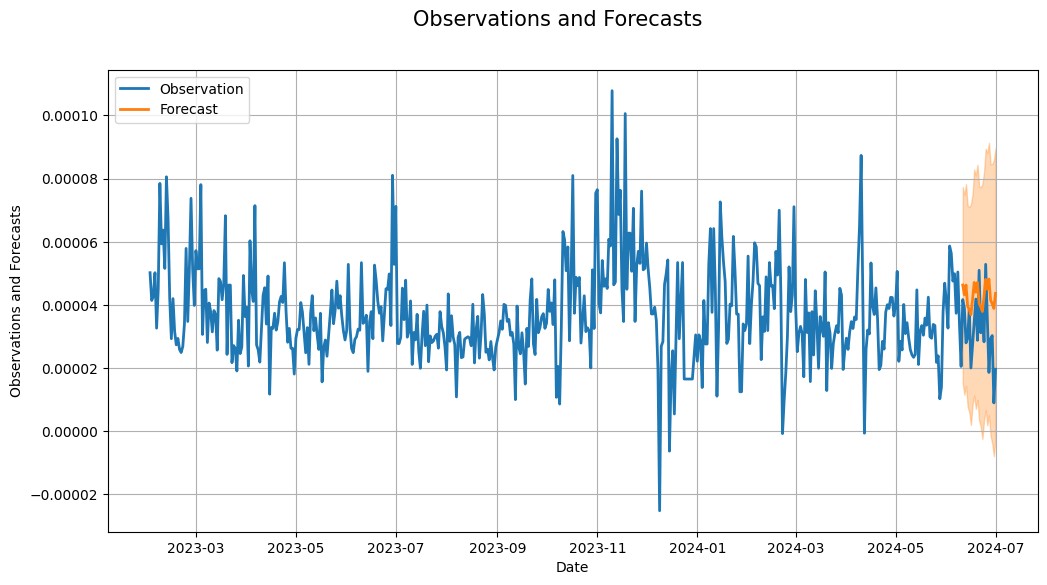

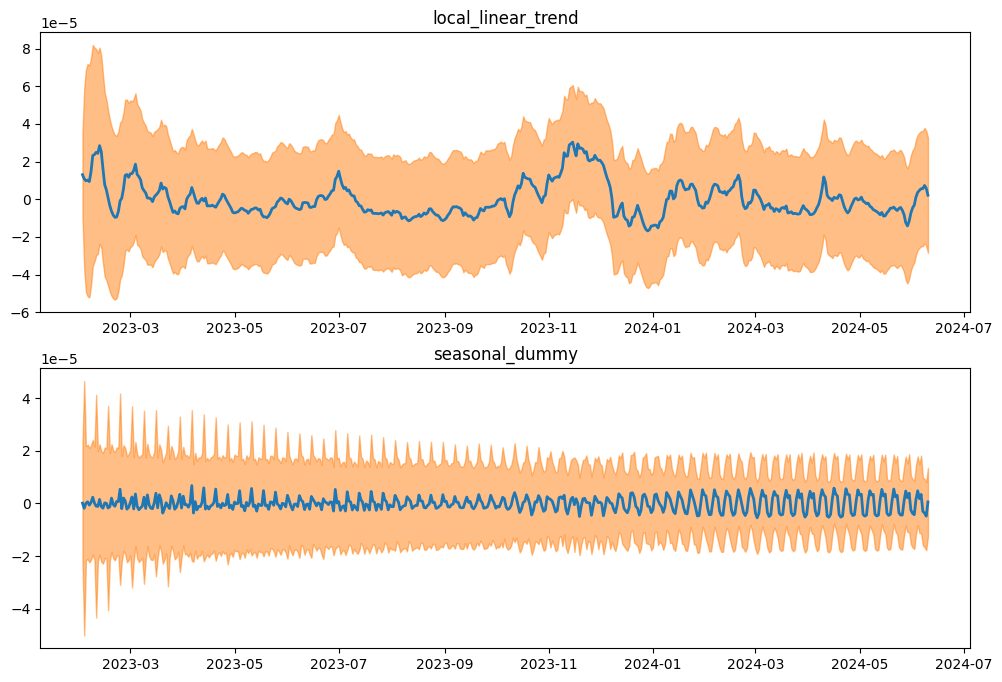

In [60]:
# Fit the model with an MLE estimator
opt_param_dummy, _losses = model_dummy_season.fit_mle(obs_time_series=obs_time_series, key=key)
opt_param_dummy

# Plot the forecast
plot_forecast(model_dummy_season, opt_param_dummy, obs_time_series=obs_time_series, num_forecast_steps=num_forecast_steps)

# Plot the decomposition
plot_decompose(model_dummy_season, opt_param_dummy, obs_time_series=obs_time_series)



##### Fit the model with the trigonometric seasonal component.

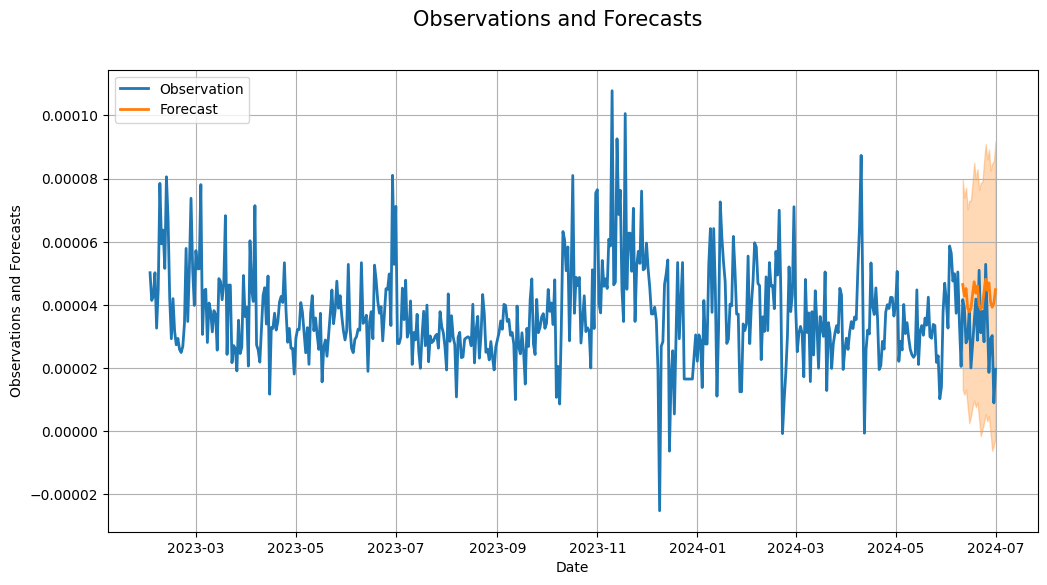

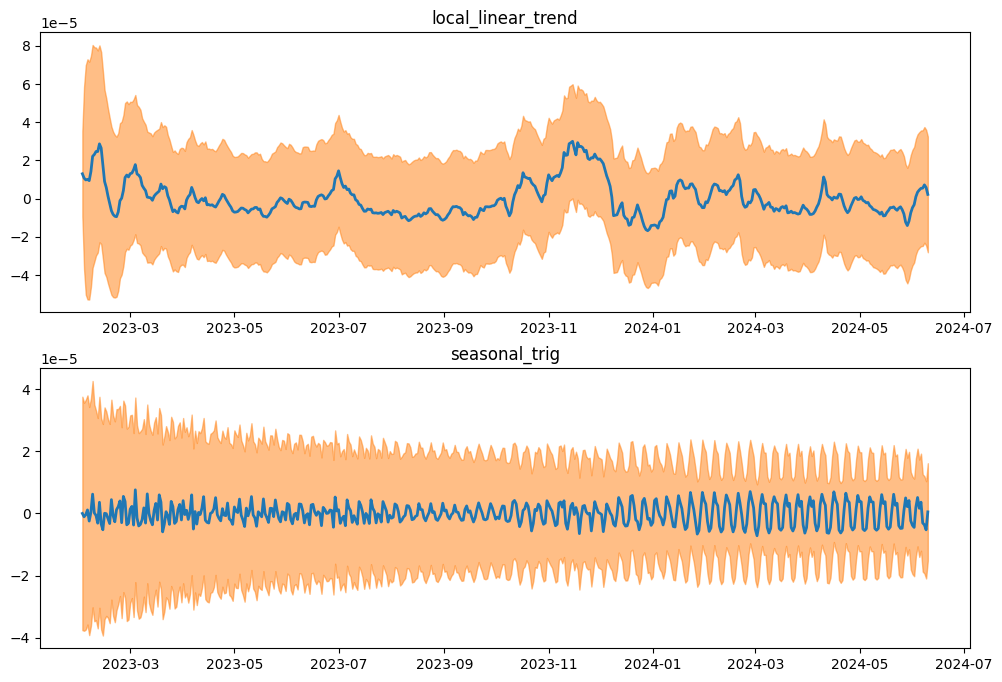

In [61]:
# Fit the model with an MLE estimator
opt_param_trig, _losses = model_trig_season.fit_mle(obs_time_series=obs_time_series, key=key)


# Plot the forecast
plot_forecast(model_trig_season, opt_param_trig, obs_time_series=obs_time_series, num_forecast_steps=num_forecast_steps)

# Plot the decomposition
plot_decompose(model_trig_season, opt_param_trig, obs_time_series=obs_time_series)



##### Fit the model with the dummy seasonal component with HMC

In [ ]:
# Fit with HMC (NUTS), initialized by MLE estimation.
param_dummy_samples, _log_probs = model_dummy_season.fit_hmc(
    num_samples=100, obs_time_series=obs_time_series, initial_params=opt_param_dummy)

# Plot the forecast
plot_forecast(model_dummy_season, param_dummy_samples, obs_time_series)

# Plot the decomposition
plot_decompose(model_dummy_season, param_dummy_samples)

##### Fit the model with the trigonometric seasonal component with HMC

In [ ]:

# Fit with HMC (NUTS), initialized by MLE estimation.
param_trig_samples, _log_probs = model_trig_season.fit_hmc(
    num_samples=100, obs_time_series=obs_time_series, initial_params=opt_param_trig)

# Plot the forecast
plot_forecast(model_trig_season, param_trig_samples, obs_time_series)

# Plot the decomposition
plot_decompose(model_trig_season, param_trig_samples)